
### Overview

    1. Data Exploration

    2. Data Cleaning

    3. Feature Engineering

    4. Preprocessing

    5. Model Building/Testing

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
train = pd.read_csv('/mnt/c/users/venturi/wsl/python/Kaggle/House Prices/train.csv')
test = pd.read_csv('/mnt/c/users/venturi/wsl/python/Kaggle/House Prices/test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Data Exlploration

    1. Identify which columns have large amounts of missing values

    2. Determine shape of ditributions

In [18]:
# Create a list of columns where the percentage of missing values is 30% or greater.

[col for col in train.columns if train[col].isnull().sum()/len(train.index) > .3]

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [19]:
num_cols = train.select_dtypes('number').columns
num_cols = num_cols.drop(['Id','MSSubClass'])

In [20]:
# for col in num_cols:
#     plt.hist(train[col])
#     plt.title(col)
#     plt.show()

For columns where most entries are 0 I wanted to check the relatioship between the parameter and saleprice. 

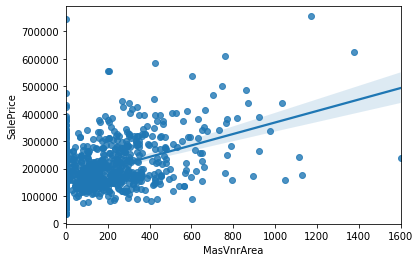

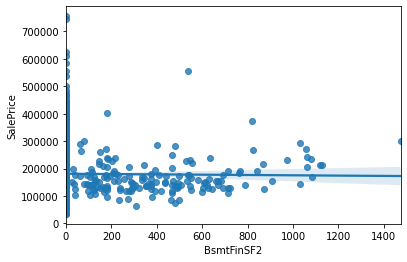

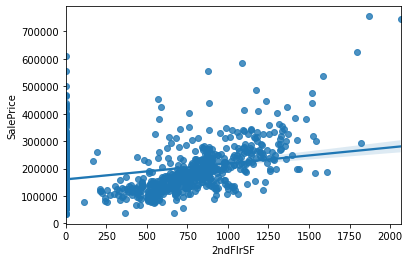

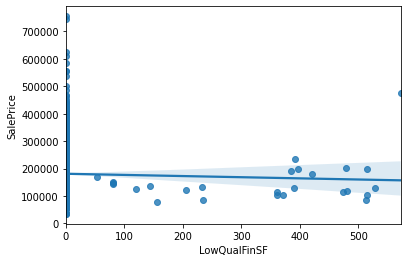

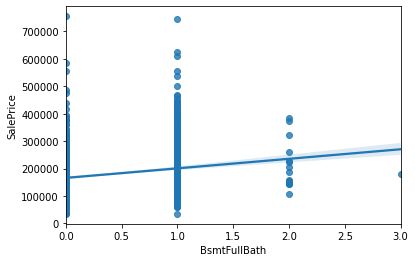

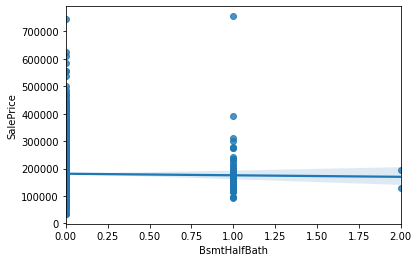

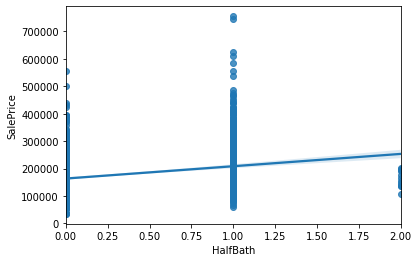

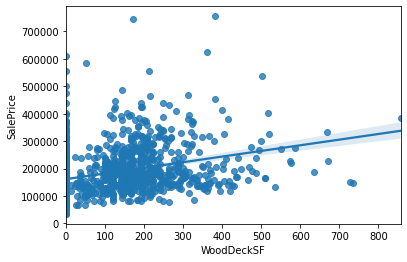

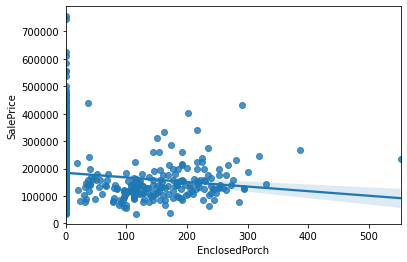

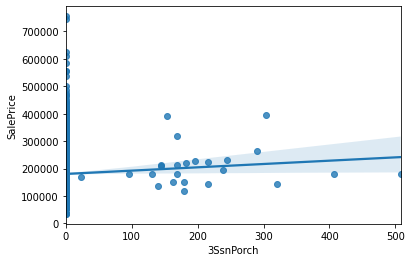

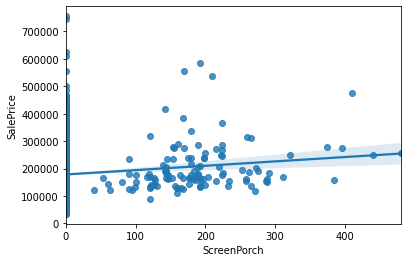

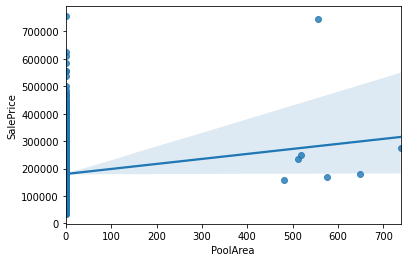

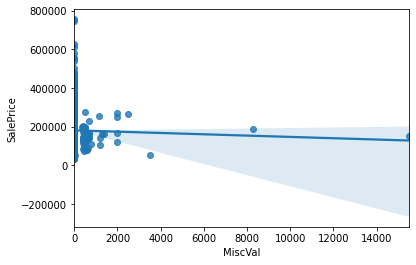

In [21]:
import seaborn as sns

areas = [col for col in num_cols if train[col].map(lambda n:n==0).sum()/len(train.index) > .5]

for col in areas:
    sns.regplot(x=col,y='SalePrice',data=train)
    plt.show()


In [22]:
train.groupby(train['FireplaceQu'].fillna('temp')).SalePrice.describe()

,count,mean,std,min,25%,50%,75%,max
FireplaceQu,,,,,,,,
Ex,24.0,337712.500000,123611.471764,130500.0,265070.00,314250.0,411324.5,755000.0
Fa,33.0,167298.484848,34287.717564,117000.0,143000.00,158000.0,187000.0,262000.0
Gd,380.0,226351.415789,91123.148369,90350.0,159671.25,206950.0,274977.5,611657.0
Po,20.0,129764.150000,31080.842115,60000.0,120925.00,131500.0,149500.0,172000.0
TA,313.0,205723.488818,71367.028772,82500.0,165000.00,187500.0,236000.0,745000.0
temp,690.0,141331.482609,44389.786884,34900.0,112000.00,135000.0,164375.0,342643.0


In [23]:
train.groupby('Fireplaces').SalePrice.describe()

,count,mean,std,min,25%,50%,75%,max
Fireplaces,,,,,,,,
0,690.0,141331.482609,44389.786884,34900.0,112000.0,135000.0,164375.0,342643.0
1,650.0,211843.909231,79531.825318,60000.0,158000.0,189975.0,254675.0,625000.0
2,115.0,240588.539130,117451.800525,100000.0,160750.0,206900.0,284500.0,755000.0
3,5.0,252000.000000,93313.986090,160000.0,190000.0,205000.0,345000.0,360000.0


We can see that for most of the homes that the garage was built the same year so I will choose YearBuilt to fill in missing values for GarageBlt. 

In [24]:
train.apply(lambda n: n.YearBuilt != n.GarageYrBlt if n.GarageYrBlt != 'NaN' else True, axis='columns').sum()

371

In [25]:
X = train.drop(['Alley','FireplaceQu','PoolArea','PoolQC','Fence','MiscFeature','SalePrice','PoolArea','MiscVal','BsmtHalfBath'], axis=1)
y = train['SalePrice']

In [26]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor

# xp_train = train.copy()
# xp_train.drop
# xp_train.GarageYrBlt.fillna(xp_train.YearBuilt, inplace=True)
# s = (xp_train.dtypes == 'object')
# obj_col = list(s[s].index)

In [27]:
# X = xp_train.drop(['SalePrice', 'MiscFeature', 'Alley', 'PoolQC', 'Fence' , 'FireplaceQu'], axis=1)
# y = xp_train.SalePrice

# numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]

# categorical_cols = [col for col in X.columns if X[col].dtype == "object"]

# train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2)

In [28]:
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error

# numerical_transformer = SimpleImputer(strategy='median')
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_cols),
#         ('cat', categorical_transformer, categorical_cols)
#     ])

# model = RandomForestRegressor(n_estimators=1000, random_state=0)
# clf = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('model', model)
#                      ])
# clf.fit(train_X, train_y)
# preds = clf.predict(val_X)

In [29]:
# print(mean_absolute_error(val_y, preds))
# print(clf.score(val_X,val_y))

In [30]:
# from xgboost import XGBRegressor

# model_2 = XGBRegressor(n_estimators=1000)
# model_2_pl = Pipeline(steps=[('preprocessor', preprocessor),
#                             ('model_2',model_2)])

# model_2_pl.fit(train_X, train_y)
# prediction = model_2_pl.predict(val_X)

# print(mean_absolute_error(val_y, prediction))
# print(model_2_pl.score(val_X,val_y))
